# Module Information Scraper
This code is to scrape assessment details from UCD module-by-module. From there, we can find out how vulnerable UCD is to ChatGPT and other similar AI helpers. First we will need to import some packages to do this.

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json

Next we will need to set the path to the datasets that we will use. This currently pulls in a specific file, that of MODULES.csv, which has all collected module information for the school of Engineering and Architecture. However, this could easily be changed to analyze sub-schools or other schools.

In [3]:
dir_raw=Path.Path("Datasets")

moduleCodes= dir_raw / "MODULES.csv"

modules=pd.read_csv(moduleCodes)

modules

,Code,Module,School
0,DSCY10060,"Energy, Climate Change & Policy",EEE
1,EEEN10010,Electronic and Electrical Engineering I,EEE
2,EEEN10020,Robotics Design Project,EEE
3,EEEN20010,Computer Engineering,EEE
4,EEEN20020,Electrical and Electronic Circuits,EEE
...,...,...,...
519,MEEN50050,Creative Thinking & Innovation,MME
520,MEEN50060,Research Techniques Space Eng,MME
521,MEEN50070,Industrial Research I,MME
522,MEEN50080,Industrial Research II,MME


The module descriptor scraper pulls all module descriptor information from the UCD module website. This includes information such as who runs the module, and importantly for our analysis, the number of credits for each module.

In [4]:
def module_descriptor_scraper(url, level=None, school=None):
    #url= "https://hub.ucd.ie/usis/!W_HU_MENU.P_PUBLISH?p_tag=MODULE&MODULE=" + modules.iloc[0]["Code"]

    request=requests.get(url)
    soup=BeautifulSoup(request.content, 'html.parser')

#print(soup)
#Create all_h1_tags as empty list
    descriptor_list={}

# Set all_h1_tags to all h1 tags of the soup
    for element in soup.select('dl'):
        credit_list=element.text
        for items in zip(soup.select('dt'), soup.select('dd')):
            #print(items[0].text + " " + items[1].text)
            descriptor_list[items[0].text]=items[1].text
        #descriptor_item.append(items[1])
        
#print("%d , %d" %(len(descriptor_type),len(descriptor_item)))

    
    module_descriptor=pd.Series(descriptor_list)
    module_descriptor["Credits:"]=pd.to_numeric(module_descriptor["Credits:"], errors='coerce')
    #print(module_descriptor)
#print(element)

    filtered=False
    
    #If filters exist, check that the module is not filtered out
    if (level != None):
        filtered= (pd.to_numeric(module_descriptor["Level:"].split('(')[0], errors='ignore') != level)
                   
    #If it wasn't filtered out by level, check if it is filtered out by school
    if (filtered == False) and (school != None):
        filtered = (module_descriptor["School:"] != school)
                   

    #if (filtered ==False) and (codeList != None):
     #   if codeList.find(code) != -1:
      #      print("%s is in the code list" %code)
       #else:
        #    filtered=True

    return module_descriptor, filtered

In [5]:
#This asserts that the filter works correctly
def assert_filtered(module_descriptors, level=None, school=None):
    all_descriptors=pd.concat(module_descriptors)
    
    if level !=None:
        assert (all_descriptors["Level:"].nunique() == 1)
    if school != None:
        assert (all_descriptors["School:"].nunique() == 1)
        
    print(all_descriptors["School:"].unique())
    return all_descriptors["School:"].nunique(), all_descriptors["Level:"].nunique()

The below code collects all module assessment and module descriptor information into two lists. It also creates a "Scaled % of Final Grade" column in the asssessment table. This weights the assessment based on the number of credits the module has overall. In this way, the median and normal amount of credits, 5.0, has assessments weighting that add up to 100%. Those above and below are given assessment weightings that scale with how much more or less they are worth then a normal module - a 10 credit module will have assessments that add up to 200%, because they are worth twice the amount as a normal module.

Error module details are stored for inspection later, to see why they occurred. The code continues on even if errors occur, after having stored these details it simply proceeds to the next module.

In [6]:
def save_module_files(module_assessments, module_descriptors, codeList=None, level=None, school=None, foldername=None):
    #The directory to save outputs to
    dir_output=Path.Path("ModuleInformation")
    dir_output.mkdir(parents=True, exist_ok=True)
    
    
    #filenames={module_assessments: "assessments", module_descriptors:"descriptors"}
    subdirectory=""
    #Save the file in its desired format
    if level != None:
        subdirectory+="Level=%d" %(level)
        
    if school != None:
        subdirectory+="_School="+school.replace(" ", "-")
    
    if codeList != None:
        subdirectory+="SelectedModules"
        
    if foldername != None:
        subdirectory=foldername
        
    #if the modules have been filtered, and thus belong in a sub directory, make that directory
    if len(subdirectory) > 0:
        dir_output=dir_output / subdirectory
        dir_output.mkdir(parents=True, exist_ok=True)
        
   
        
    #Save our two module detail files
    with open(dir_output / "assessments.json", 'w') as outfile:
        if len(module_assessments) > 2:
            module_assessments=pd.concat(module_assessments, ignore_index=True)
            #print(module_assessments)
        print("saving to %s" % dir_output)
        outfile.write(module_assessments.to_json())
        
    with open(dir_output / "descriptors.json", 'w') as outfile:
        print("saving to %s" % dir_output)
        if len(module_descriptors) > 2:
            module_descriptors=pd.DataFrame(module_descriptors)
        outfile.write(module_descriptors.to_json())

In [33]:
#This functiom will allow school and year functions to be placed on it
def collector(codeList=None, level=None, school=None, foldername=None):
    #This stores module information
    module_assessments=[]
    module_descriptors=[]

    #This stores error module information
    error_modules=[]
    error_module_descriptors=[]

    moduleCodes
    #Pick where to get the module codes from
    if codeList!=None:
        modulesCodes=codeList
    else:
        modulesCodes=modules["Code"].iloc
    for i in modulesCodes:
        print(".",end="")
        
        #Check that the code is allowed 
        #if codeList !=None:
        #    if codeList.find(i["Code"]) != -1:
        #        print("%s is in the code list" %i["Code"])
        #    else:
         #       continue
            
        url= "https://hub.ucd.ie/usis/!W_HU_MENU.P_PUBLISH?p_tag=MODULE&MODULE=" + i

        #Get the module descriptor
        descriptor, filtered=module_descriptor_scraper(url, level=level, school=school)
        #If the module is in violation of the filters, continue to the next without saving
        if filtered==True:
            continue
        #Use pandas to read in the asssessment html tables too
        table=pd.read_html(url, match="Description")
        
        #print(descriptor)
        #Get the first table, and turn it into a dataframe
        df=pd.DataFrame(table[0])
        df["Assessment Type"] = df['Description'].str.split(':').str[0]
        try:
            df["Scaled % of Final Grade"]= df['% of Final Grade'].apply(lambda x: x * (descriptor["Credits:"]/5.0))
        except:
            print("\nERROR MODULE DETECTED.")
            #print(df["% of Final Grade"])
            #print(descriptor["Credits:"])
            print("Module may need to be inspected, saving information as an error module and continuing without it")
        
            error_modules.append(df)
            error_module_descriptors.append(descriptor)
            #Continue after noting and saving the error
            continue
        
        #Append the dataframe to the module assessments list
        module_assessments.append(df)
        module_descriptors.append(descriptor)
    
    #This asserts that the filters were properly imposed, if imposed at all
    num_schools, num_levels=assert_filtered(module_descriptors, level, school)

    print("\nFINISHED, SCRAPED DETAILS ON %d MODULES, OVER %d SCHOOLS AND %d LEVELS" \
          %(len(module_assessments), num_schools, num_levels))
    
    #Save the output files
    save_module_files(module_assessments, module_descriptors, codeList=codeList, level=level, school=school, \
                      foldername=foldername)
    
    return module_assessments, module_descriptors, error_modules, error_module_descriptors



In [34]:
#Run the above function in its base form
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector()

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..........................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
...................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module 

In [27]:
def excelListReader(filename, excel_table=True):

    coreCodes= dir_raw / filename

    if excel_table:
        coreModules=pd.read_excel(coreCodes)
    
        coreList=coreModules["Module"].values.tolist()
        
    else:
        coreModules=pd.read_excel(coreCodes, header=None)
    
        coreList=coreModules.values.tolist()

   # coreModules="-".join(x)

    print(coreList)
    
    return coreList

In [22]:
module_assessments, module_descriptors, error_modules, error_module_descriptors\
=collector(codeList=excelListReader("UCD_EngArch_Path_Electronic_UG_Modules.xlsx"), foldername="ElectricalPath")

['CHEM10030', 'CHEN10040', 'CVEN10040', 'EEEN10010', 'MATH10250', 'PHYC10150', 'MATH10260', 'MEEN10030', 'MEEN10050', 'PHYC10160', 'COMP10060', 'EEEN10020', 'EEEN20010', 'EEEN20020', 'EEEN20050', 'EEEN20070', 'MATH20290', 'EEEN20030', 'EEEN20040', 'EEEN20060', 'EEEN20090', 'STAT20060', 'SCI20020', 'COMP20200', 'ACM30030', 'COMP20080', 'EEEN30020', 'EEEN30110', 'EEEN30030', 'EEEN30050', 'EEEN30120', 'EEEN30150', 'EEEN30190', 'EEEN30060', 'EEEN30160', 'COMP20180']
....................................['Chemistry' 'Chem & Bioprocess Engineering' 'Civil Engineering'
 'Electrical & Electronic Eng' 'Mathematics & Statistics' 'Physics'
 'Mechanical & Materials Eng' 'Computer Science']

FINISHED, SCRAPED DETAILS ON 36 MODULES, OVER 8 SCHOOLS AND 3 LEVELS
saving to ModuleInformation\ElectricalPath
saving to ModuleInformation\ElectricalPath


In [29]:
module_assessments, module_descriptors, error_modules, error_module_descriptors\
=collector(codeList=excelListReader("UCD_EngArch_Path_Architecture_UG_Modules.xlsx"), foldername="ArchitecturePath")

['ARCT10010', 'ARCT10030', 'ARCT10070', 'ARCT10120', 'ARCT10020', 'ARCT10040', 'ARCT10090', 'CVEN10060', 'ARCT20020', 'ARCT20040', 'ARCT20050', 'ARCT20130', 'ARCT20010', 'ARCT20100', 'CVEN20040', 'ARCT20170', 'ARCT30010', 'ARCT30030', 'ARCT30090', 'CVEN30100', 'ARCT30040', 'ARCT30100', 'ARCT30130', 'ARCT20170']
........................['Architecture, Plan & Env Pol' 'Civil Engineering']

FINISHED, SCRAPED DETAILS ON 24 MODULES, OVER 2 SCHOOLS AND 3 LEVELS
saving to ModuleInformation\ArchitecturePath
saving to ModuleInformation\ArchitecturePath


In [31]:
module_assessments, module_descriptors, error_modules, error_module_descriptors\
=collector(codeList=excelListReader("UCD_EngArch_Path_Mechanical_UG_Modules.xlsx"), foldername="MechanicalPath")

['CHEM10030', 'CHEN10040', 'CVEN10040', 'EEEN10010', 'MATH10250', 'PHYC10150', 'MATH10260', 'MEEN10030', 'MEEN10050', 'PHYC10160', 'COMP10060', 'DSCY10060', 'EEEN20020', 'MATH20290', 'MEEN20010', 'MEEN20020', 'MEEN20050', 'MEEN20030', 'MEEN20040', 'MEEN20060', 'MEEN20070', 'STAT20060', 'COMP20080', 'SCI20020', 'ACM30030', 'MEEN30030', 'MEEN30040', 'MEEN30090', 'MEEN30100', 'EEEN20090', 'EEEN30150', 'MEEN30010', 'MEEN30020', 'MEEN30140', 'MEEN30130', 'MEEN30160']
....................................['Chemistry' 'Chem & Bioprocess Engineering' 'Civil Engineering'
 'Electrical & Electronic Eng' 'Mathematics & Statistics' 'Physics'
 'Mechanical & Materials Eng' 'Computer Science']

FINISHED, SCRAPED DETAILS ON 36 MODULES, OVER 8 SCHOOLS AND 3 LEVELS
saving to ModuleInformation\MechanicalPath
saving to ModuleInformation\MechanicalPath


In [10]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=1)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................['Electrical & Electronic Eng' 'Civil Engineering'
 'Chem & Bioprocess Engineering' 'Biosystems & Food Engineering'
 'Architecture, Plan & Env Pol' 'Mechanical & Materials Eng']

FINISHED, SCRAPED DETAILS ON 32 MODULES, OVER 6 SCHOOLS AND 1 LEVELS
saving to ModuleInformation\Level=1
saving to ModuleInformation\Level=1


In [11]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=2)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................['Electrical & Electronic Eng' 'Civil Engineering'
 'Chem & Bioprocess Engineering' 'Biosystems & Food Engineering'
 'Architecture, Plan & Env Pol' 'Mechanical & Materials Eng']

FINISHED, SCRAPED DETAILS ON 55 MODULES, OVER 6 SCHOOLS AND 1 LEVELS
saving to ModuleInformation\Level=2
saving to ModuleInformation\Level=2


In [12]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=3)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................['Electrical & Electronic Eng' 'Civil Engineering'
 'Chem & Bioprocess Engineering' 'Biosystems & Food Engineering'
 'Architecture, Plan & Env Pol' 'Mechanical & Materials Eng']

FINISHED, SCRAPED DETAILS ON 88 MODULES, OVER 6 SCHOOLS AND 1 LEVELS
saving to ModuleInformation\Level=3
saving to ModuleInformation\Level=3


In [13]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=4)

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..........................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
...................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module 

In [14]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=5)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
....['Electrical & Electronic Eng' 'Chem & Bioprocess Engineering'
 'Architecture, Plan & Env Pol' 'Mechanical & Materials Eng']

FINISHED, SCRAPED DETAILS ON 12 MODULES, OVER 4 SCHOOLS AND 1 LEVELS
saving to ModuleInformation\Level=5
saving to ModuleInformation\Level=5


In [15]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Mechanical & Materials Eng")

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
........................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..................

In [16]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Civil Engineering")

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....................................................................................................................................................................................................................................................................................................................................................................................................................['Civil Engineering']

FINISHED, SCRAPED DETAILS ON 57 MODULES, OVER 1 SCHOOLS AND 4 LEVELS
saving to ModuleInformation\_School=Civil-Engineering
saving to ModuleInformation\_School=Civil-Engineering


In [17]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Chem & Bioprocess Engineering")

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................['Chem & Bioprocess Engineering']

FINISHED, SCRAPED DETAILS ON 67 MODULES, OVER 1 SCHOOLS AND 5 LEVELS
saving to ModuleInformation\_School=Chem-&-Bioprocess-Engineering
saving to ModuleInformation\_School=Chem-&-Bioprocess-Engineering


In [18]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Biosystems & Food Engineering")

.................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
...........................................................................................................................................................................................................................................................................................['Biosystems & Food Engineering']

FINISHED, SCRAPED DETAILS ON 64 MODULES, OVER 1 SCHOOLS AND 4 LEVELS
saving to ModuleInformation\_School=Biosystems-&-Food-Engineering
saving to ModuleInformation\_School=Biosystems-&-Food-Engineering


In [19]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Architecture, Plan & Env Pol")

....................................................................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
........................................................................................................................................................................................................................

In [20]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Electrical & Electronic Eng")

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................['Electrical & Electronic Eng']

FINISHED, SCRAPED DETAILS ON 66 MODULES, OVER 1 SCHOOLS AND 5 LEVELS
saving to ModuleInformation\_School=Electrical-&-Electronic-Eng
saving to ModuleInformation\_School=Electrical-&-Electronic-Eng


In [21]:
#Inspect the error modules just in case
for i, error in enumerate(zip(error_modules, error_module_descriptors)):
    print("********ERROR COUNT %d*********" %i)
    print(error[0])
    print(error[1])
    

Next we combine all the modules assessment information together, ready for later aggregation and analysis.

In [22]:
aggreg_modules=pd.concat(module_assessments)

aggreg_modules

,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Scaled % of Final Grade
0,Group Project: Multidisciplinary Group Assignment,Throughout the Trimester,NaN,Graded,No,50,Group Project,50.0
1,Examination: End of trimester MCQ,End of trimester MCQ,No,Standard conversion grade scale 40%,No,50,Examination,50.0
0,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,65.0
1,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,NaN,Alternative linear conversion grade scale 40%,No,10,Lab Report,10.0
2,Continuous Assessment: 3 Online quizzes: 1) ci...,Varies over the Trimester,NaN,Alternative linear conversion grade scale 40%,No,25,Continuous Assessment,25.0
...,...,...,...,...,...,...,...,...
3,Assignment: Students must demonstrate that the...,Throughout the Trimester,NaN,Pass/Fail Grade Scale,Yes,20,Assignment,20.0
4,Assignment: Creation of a polished slide deck ...,Throughout the Trimester,NaN,Graded,No,10,Assignment,10.0
5,Assignment: Exercise to demonstrate a fluent w...,Throughout the Trimester,NaN,Graded,No,30,Assignment,30.0
0,Assignment: Three reports.,Throughout the Trimester,NaN,Graded,No,100,Assignment,200.0


In [23]:
assessments=aggreg_modules[["Assessment Type", "% of Final Grade"]]

#This is the dataset cleaning, so that they are ready for presentation
assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
assessments=assessments.dropna()
assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")

assessments

C:\Users\catha\AppData\Local\Temp\ipykernel_40472\1516520741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


,Assessment Type,% of Final Grade
0,Group Project,50
1,Examination,50
0,Examination,65
1,Lab Report,10
2,Continuous Assessment,25
...,...,...
3,Assignment,20
4,Assignment,10
5,Assignment,30
0,Assignment,100


In [24]:
assessments.describe()

,% of Final Grade
count,187.000000
mean,35.294118
std,25.044136
min,5.000000
25%,15.000000
50%,30.000000
75%,50.000000
max,100.000000


In [25]:
#assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
assessments["Assessment Type"].value_counts()

Examination                      42
Assignment                       35
Lab Report                       29
Continuous Assessment            18
Project                          15
Class Test                       13
Presentation                     12
Essay                             8
Oral Examination                  6
Group Project                     4
Fieldwork                         2
Multiple Choice Questionnaire     2
Attendance                        1
Name: Assessment Type, dtype: int64

In [26]:
assessments["Assessment Type"].nunique()

13

In [27]:
#assessments = assessments.drop("No yet recorded.")
assessment_average=assessments.groupby(by="Assessment Type", as_index=False).mean()

assessment_average

,Assessment Type,% of Final Grade
0,Assignment,36.571429
1,Attendance,10.000000
2,Class Test,20.769231
3,Continuous Assessment,23.611111
4,Essay,13.750000
5,Examination,49.404762
6,Fieldwork,100.000000
7,Group Project,41.250000
8,Lab Report,28.068966
9,Multiple Choice Questionnaire,20.000000


In [28]:
sorted_averages=assessment_average.sort_values("% of Final Grade", ascending=False)

sorted_averages

,Assessment Type,% of Final Grade
6,Fieldwork,100.000000
10,Oral Examination,64.166667
5,Examination,49.404762
12,Project,46.066667
7,Group Project,41.250000
0,Assignment,36.571429
8,Lab Report,28.068966
3,Continuous Assessment,23.611111
2,Class Test,20.769231
9,Multiple Choice Questionnaire,20.000000


Text(0.5, 1.0, 'Average Module Percentage When Assessment Type is Used')

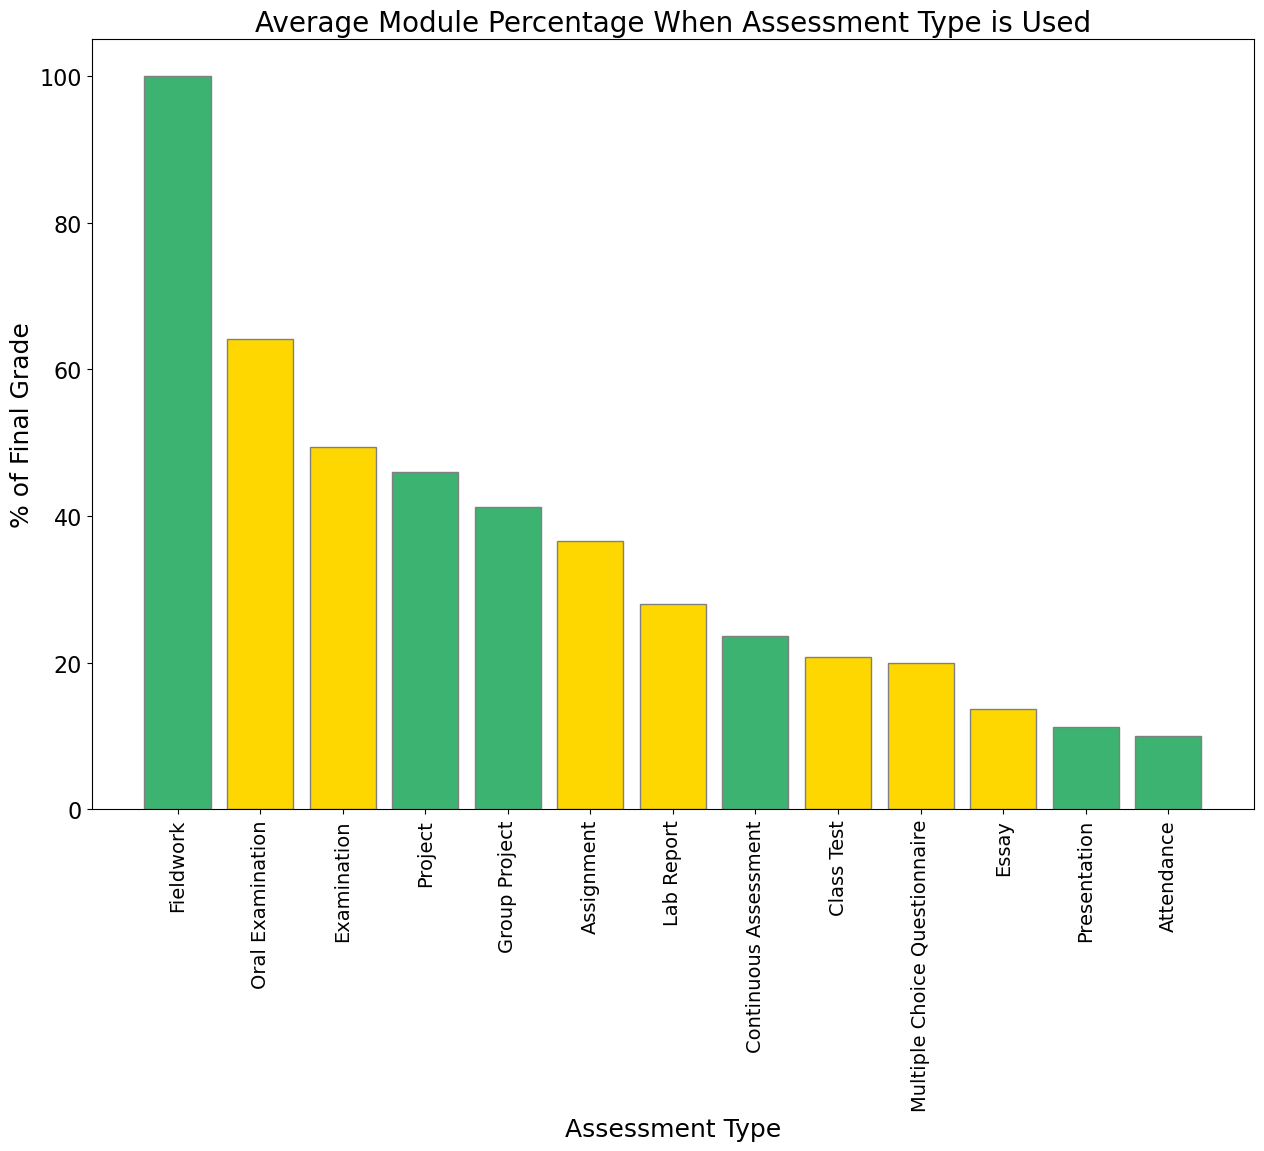

In [29]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots( figsize=(15, 10))

#barWidth=0.25
colormap={"Essay": "gold", "Assignment": "gold", "Examination": "mediumseagreen", "Attendance": "mediumseagreen", \
          "Class Test":"mediumseagreen", "Continuous Assessment": "gold", "Fieldwork": "mediumseagreen", "Group Project": "gold",\
         "Journal": "gold", "Lab Report" : "mediumseagreen", "Multiple Choice Questionnaire (MCQ)": "mediumseagreen", \
          "Oral Examination" : "mediumseagreen", "Portfolio": "gold", "Practical Examination": "mediumseagreen",\
          "Presentation":"mediumseagreen", "Project": "gold", "Seminar": "mediumseagreen",\
          "Studio Examination": "mediumseagreen", "Assessments worth <2%": "mediumseagreen"}

# Make the plot
ax.bar(sorted_averages["Assessment Type"], sorted_averages["% of Final Grade"], edgecolor="grey", color=["mediumseagreen", "gold", \
"gold", "mediumseagreen", "mediumseagreen", "gold", "gold",  "mediumseagreen", "gold", "gold", "gold", "mediumseagreen",\
                                                                                       "mediumseagreen", "mediumseagreen", \
                                                "mediumseagreen", "gold", "mediumseagreen", "mediumseagreen"] )


#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', rotation=90, labelsize=14)
#ax.legend(fontsize=20)
ax.set_xlabel("Assessment Type", fontsize=18)
ax.set_ylabel("% of Final Grade",fontsize=18)
#Add the date lines for context
ax.set_title("Average Module Percentage When Assessment Type is Used", fontsize=20)

In [30]:
assessment_total=assessments.groupby(by="Assessment Type", as_index=False).sum()
 
assessment_total

,Assessment Type,% of Final Grade
0,Assignment,1280
1,Attendance,10
2,Class Test,270
3,Continuous Assessment,425
4,Essay,110
5,Examination,2075
6,Fieldwork,200
7,Group Project,165
8,Lab Report,814
9,Multiple Choice Questionnaire,40


In [31]:
total=assessment_total["% of Final Grade"].sum()

assessment_total["% of Assessment"]=assessment_total["% of Final Grade"].apply(lambda x: x/total)
assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.add_categories("Assessments worth <2%")
assessment_total.loc[assessment_total["% of Assessment"] < 0.02, "Assessment Type"] = "Assessments worth <2%"

assessment_total

,Assessment Type,% of Final Grade,% of Assessment
0,Assignment,1280,0.193939
1,Assessments worth <2%,10,0.001515
2,Class Test,270,0.040909
3,Continuous Assessment,425,0.064394
4,Assessments worth <2%,110,0.016667
5,Examination,2075,0.314394
6,Fieldwork,200,0.030303
7,Group Project,165,0.025000
8,Lab Report,814,0.123333
9,Assessments worth <2%,40,0.006061


In [32]:
assessment_total["Assessment Type"]= assessment_total["Assessment Type"].cat.remove_categories(["Fieldwork", "Journal", \
                                                                             "Attendance", "Oral Examination", \
                                                "Practical Examination", "Seminar", "Studio Examination",\
                                                                                             "Multiple Choice Questionnaire"])

assessment_total

ValueError: removals must all be in old categories: {'Practical Examination', 'Journal', 'Seminar', 'Studio Examination'}

In [ ]:
filtered_asses=assessment_total.groupby(by="Assessment Type").sum()

pie_assessment=filtered_asses["% of Assessment"]

sorted_totals=pie_assessment.sort_values(ascending=False)

sorted_totals

In [ ]:
fig, ax=plt.subplots(figsize=(15,12))

#exploded=[0.03, 0, 0.03, 0.03, 0, 0.03, 0.03, 0.03, 0, 0, 0]
ax.pie(sorted_totals, wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'grey' }, \
       autopct="%1.1f%%", labels=sorted_totals.index, colors=["gold","mediumseagreen", \
"gold", "gold", "mediumseagreen",  "gold", "gold", "gold", "mediumseagreen",\
                                                              "mediumseagreen", "mediumseagreen", "mediumseagreen"])

#my_circle=ax.Circle( (0,0), 0.7, color='white')
#p=ax.gcf()

ax.set_title("Assessment type as a Percentage of Module Assessments", fontsize=20)